#### Project: Housing prices dataset from the Kaggle competition "House Prices: Advanced Regression Techniques." This Ames Housing dataset was compiled by Dean De Cock.

#### Programmer: Ricardo A. Leal

#### Date: 08/30/2020
#### Problem: 
Predict the sales price of each house in the test set. This problem can be solved with regression algorithms.

#### Skills practiced in this project: 
Feature engineering, PCA, hyperparameter tuning, scaling, cross validation, skew transformation and data visualization.

##### Note: 
Some of my features are processed in a similar way to what I have learn on different machine learning courses, books and websites. This is a basic project to get familiar with machine learning techniques.

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA

#ML models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso

#Set seed to reproduce results
np.random.seed(33)
#Ignore warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Get data
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [3]:
#Save Id for the submission
test_id = test_set['Id'].copy()

#Drop Id column and update dataframe
train_set = train_set.drop(['Id'], axis = 1)
test_set = test_set.drop(['Id'], axis = 1)

# Explore data

In [4]:
print("Train info:\n")
train_set.info()

Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  


In [5]:
print("\n\nTest info:\n")
test_set.info()



Test info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  

### Train set

In [6]:
#Check statistics of the target variable
print("Statistics of SalePrice:\n", train_set['SalePrice'].describe())

Statistics of SalePrice:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64



Skewness of SalePrice 1.8828757597682129


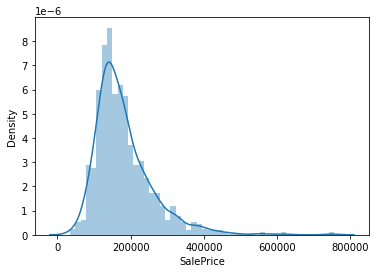

In [7]:
#Check skewness of the target variable
print("\nSkewness of SalePrice", train_set['SalePrice'].skew())

#Check the distribution of the target
sns.distplot(train_set['SalePrice'], bins = 50)

The distribution of the SalePrice is positively skewed. We can see that the majority of the houses are in the
range between \\$100,000 and \\$300,000. There is also a substantial difference between the minimum sale price and
the max sale price. Also, some houses are worth more than twice the average of the SalePrice.
To solve these big differences, I will apply np.log1 to normalize more the distribution of the target variable and reduce the range of the values.

In [8]:
#Log(1 + x) transformation
train_set['SalePrice'] = np.log1p(train_set['SalePrice'])

In [9]:
#Explore data again
#Check statistics
print("Statistics of SalePrice after the log transformation:\n", train_set['SalePrice'].describe())

Statistics of SalePrice after the log transformation:
 count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64



Skewness of SalePrice 0.12134661989685333


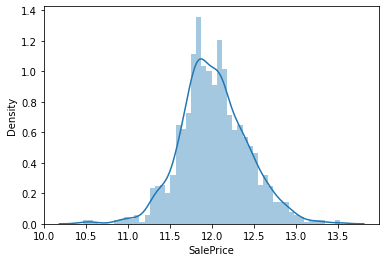

In [10]:
#Check new skewness after the transformation
print("\nSkewness of SalePrice", train_set['SalePrice'].skew())
#Check the distribution of the target
sns.distplot(train_set['SalePrice'], bins = 50)

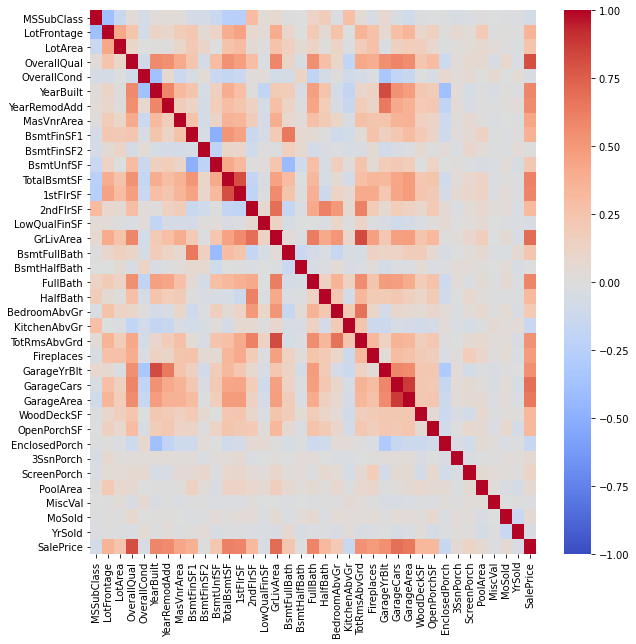

In [11]:
#Heatmap of the correlations
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(train_set.corr(), vmin = -1, vmax = 1, center = 0,cmap = "coolwarm")

I could have used the 'annot' parameter in the heatmap but, there are too many features to add the
correlation values in each cell on the heatmap. However, I will show a list of those values.

In [12]:
#Correlations
print(train_set.corr(method = 'pearson')['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64


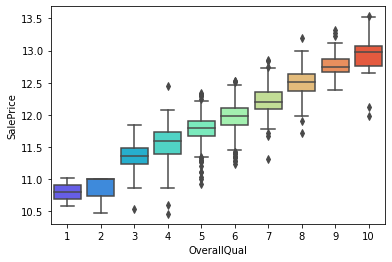

In [13]:
#Boxplot OverallQual vs SalePrice
sns.boxplot(x="OverallQual", y="SalePrice", data=train_set, palette='rainbow')

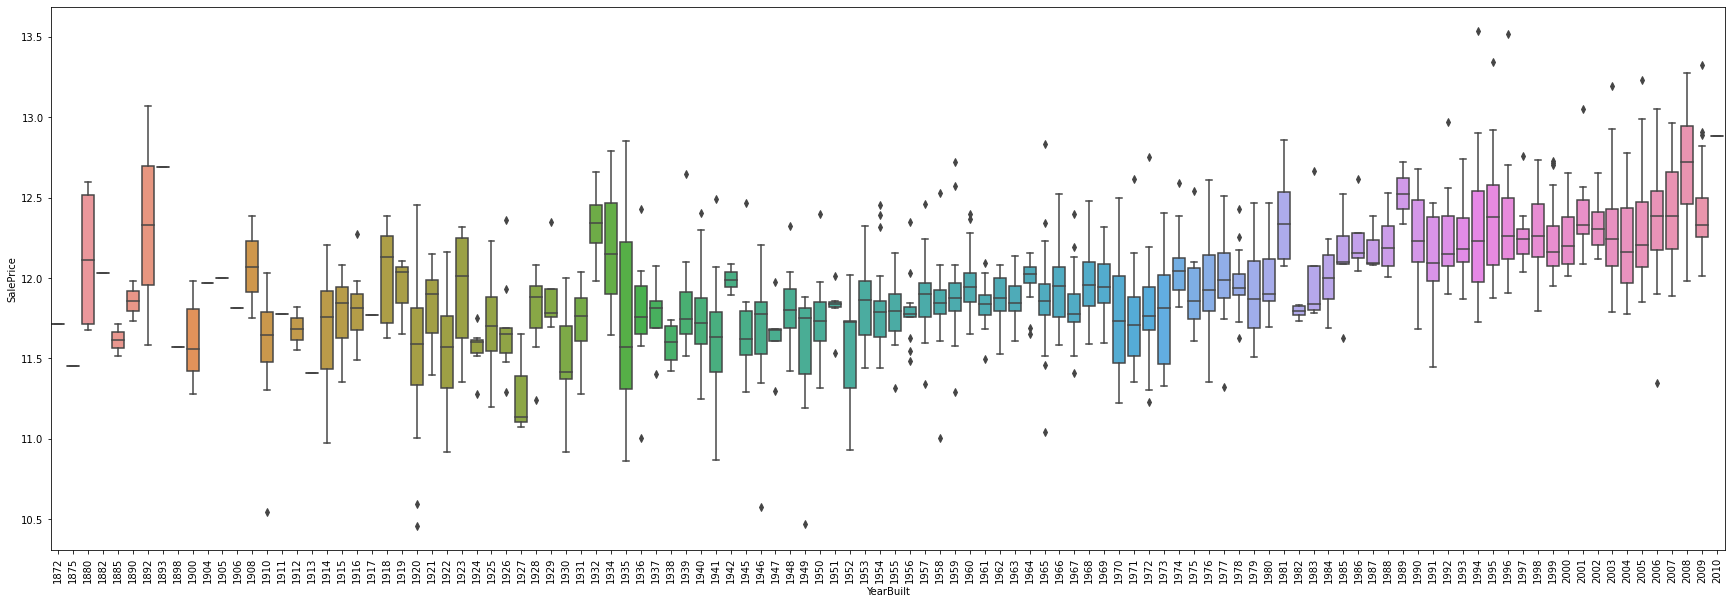

In [14]:
#Boxplot YearBuilt vs SalePrice
fig, ax = plt.subplots(figsize = (30,10))
plt.xticks(rotation=90)
sns.boxplot(x="YearBuilt", y="SalePrice", data=train_set)

I created a function to check which columns are missing values in a dataset

In [15]:
#Function 'getColumnsWithMissingValues': 
#Returns a list of the names of the columns with missing values. 
#Parameters: Pandas DataFrame
def getColumnsWithMissingValues(dataFrame):

    #Get a Pandas Series where the columns with missing values 
    missing_values = (dataFrame.isnull().sum().sort_values(ascending = False) > 0)

    #Make it into a dataframe to filter values. After this step, the column names will become index labels 
    #in the dataframe. However, we can filter them by checking which row has a value of True in the series
    missing_values_df = pd.DataFrame(missing_values[missing_values == True]) 
    
    #Convert the index labels into a list and return the list
    return missing_values_df.index.values.tolist()


In [16]:
#Get a pandas series with the percentage of missing values in this set
percent_missing_values_train = (train_set.isnull().sum() * 100) / len(train_set)

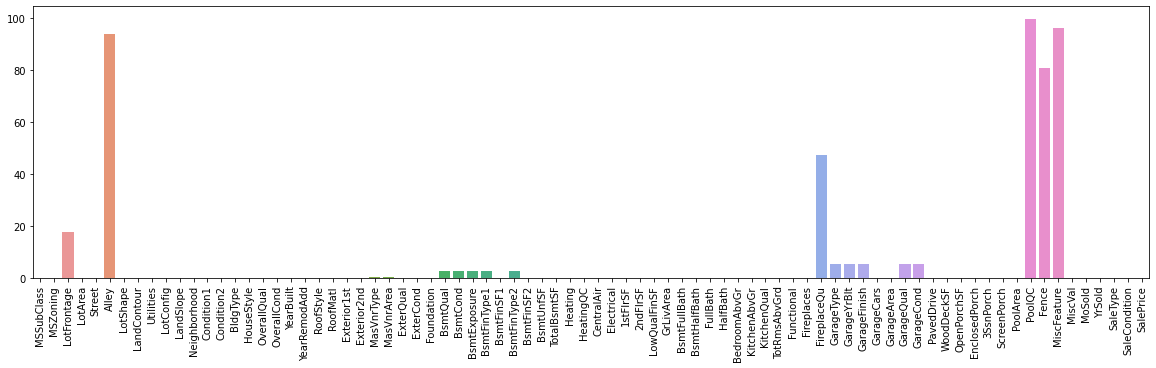

In [17]:
#Convert the series into a dataframe
missing_df_train = pd.DataFrame(percent_missing_values_train)
#Previously, the pandas series had the name of the columns as index labels. To fix this, I 
#will transpose the dataframe to get the index labels as column names and the percentages in a single row
missing_df_train = missing_df_train.transpose()
#Show a barplot of the data
fig, ax = plt.subplots(figsize= (20,5))
plt.xticks(rotation=90)
sns.barplot(data = missing_df_train)
plt.show()

In [18]:
#Get the list of columns with missing values.
#The values of this list will be used to replace the missing values later
column_names_train = getColumnsWithMissingValues(train_set)
#Print how many columns are missing values
print("There are", len(column_names_train), "columns with missing values in the training set")

#Some percentages are so small that are not visible in the bar plot. With this list we can see the actual numbers
print("\nColumn\t\tMissing %\n")
print(percent_missing_values_train.sort_values(ascending = False).head(len(column_names_train)))

There are 19 columns with missing values in the training set

Column		Missing %

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageYrBlt      5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


In [19]:
#Drop columns that are missing too many values
train_set = train_set.drop(['PoolQC', 'Alley', 'Fence',
                          'FireplaceQu', 'LotFrontage'], axis = 1)

### Test set

In [20]:
#Get a pandas series with the percentage of missing values in this set
percent_missing_values_test = (test_set.isnull().sum() * 100) / len(test_set)

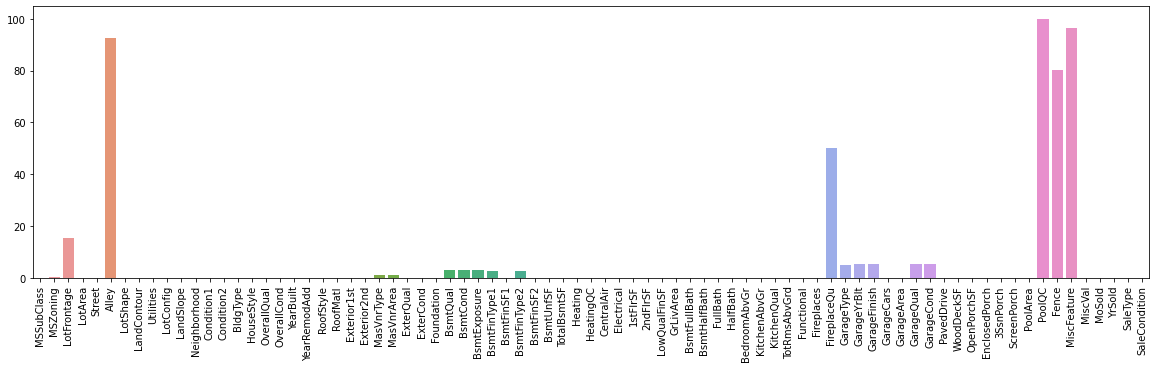

In [21]:
#Convert series into a dataframe
missing_df_test = pd.DataFrame(percent_missing_values_test)
#Previously, the pandas series had the name of the columns as index labels. To fix this, I 
#will transpose the dataframe to get the index labels as column names and the percentages in a single row
missing_df_test = missing_df_test.transpose()
#Show a barplot of the data
fig, ax = plt.subplots(figsize= (20,5))
plt.xticks(rotation=90)
sns.barplot(data = missing_df_test)
plt.show()

In [22]:
#Get the list of columns with missing values.
#The values of this list will be used to replace the missing values later
column_names_test = getColumnsWithMissingValues(test_set)
#Print how many columns are missing values
print("There are", len(column_names_test), "columns with missing values in the test set")
#Some percentages are so small that are not visible in the bar plot. With this list we can see the actual numbers
print("\nColumn\t\tMissing %\n")
print(percent_missing_values_test.sort_values(ascending = False).head(len(column_names_test)))

There are 33 columns with missing values in the test set

Column		Missing %

PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageCond       5.346127
GarageFinish     5.346127
GarageYrBlt      5.346127
GarageQual       5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType1     2.878684
BsmtFinType2     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
BsmtHalfBath     0.137080
Utilities        0.137080
Functional       0.137080
BsmtFullBath     0.137080
BsmtFinSF2       0.068540
BsmtFinSF1       0.068540
BsmtUnfSF        0.068540
TotalBsmtSF      0.068540
Exterior2nd      0.068540
SaleType         0.068540
Exterior1st      0.068540
KitchenQual      0.068540
GarageArea       0.068540
GarageCars       0.068540
dtype: float64


In [23]:
#Drop columns that are missing too many values
test_set = test_set.drop(['PoolQC', 'Alley', 'Fence',
                          'FireplaceQu', 'LotFrontage'], axis = 1)

## Looking for outliers

I will take a look to the variables that have a high correlation with the target variable

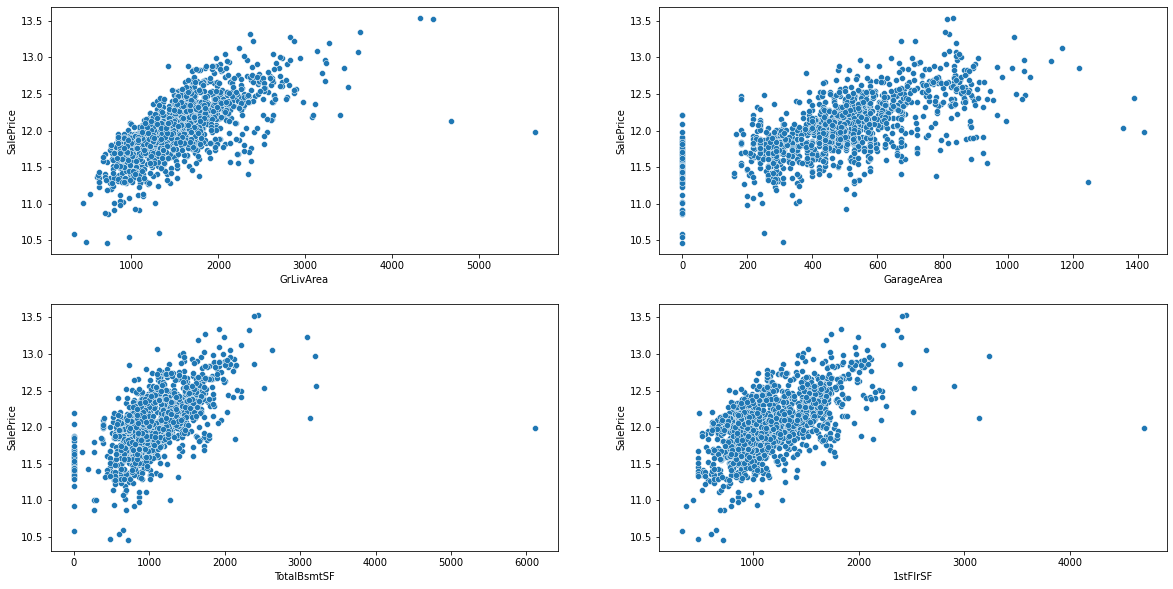

In [24]:
#Show multiple plots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(x="GrLivArea", y="SalePrice", data=train_set, ax=ax[0, 0])

sns.scatterplot(x="GarageArea", y="SalePrice", data=train_set, ax=ax[0, 1])

sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=train_set, ax=ax[1, 0])

sns.scatterplot(x="1stFlrSF", y="SalePrice", data=train_set, ax=ax[1, 1])

In [25]:
#Delete these outliers
train_set.drop(train_set[(train_set['GrLivArea'] > 4000) & (train_set['SalePrice'] < 12.5)].index,
               inplace = True)

train_set.drop(train_set[(train_set['GarageArea'] > 1200) & (train_set['SalePrice'] < 12.7)].index,
               inplace = True)

train_set.drop(train_set[(train_set['GarageArea'] > 200) & (train_set['SalePrice'] < 10.7)].index,
               inplace = True)

train_set.drop(train_set[(train_set['TotalBsmtSF'] > 5000) & (train_set['SalePrice'] < 12.5)].index,
               inplace = True)

train_set.drop(train_set[(train_set['1stFlrSF'] > 4000) & (train_set['SalePrice'] < 12.5)].index,
               inplace = True)

##### Remove target from train set to have the same number of columns as the test set

In [26]:
#Remove SalePrice from the train set to have the same shape as the test set

salePrice_train = train_set['SalePrice'].copy()
train_set = train_set.drop('SalePrice', axis = 1)

# Replacing missing values

MiscFeature and other variables listed below, are special features whose NaN values should be replaced with the
mean or mode. The reason for this is that the training examples with NaN as value in those columns mean that
they do not have that feature at all. To solve this problem, I will replace those NaN values for the 
string "None" instead of the mode.

In [27]:
special_case_columns = ['MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
 
#Replace the NaN values in the especial columns    
for column in special_case_columns:
    train_set[column].replace({np.NaN: "None"}, inplace = True)
    test_set[column].replace({np.NaN: "None"}, inplace = True)

I am going to transform some features that are listed as numerical features but
they are actually categorical features.

In [28]:
actually_categorical_columns = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                        'GarageYrBlt', 'MoSold', 'YrSold']

#Convert the numerical values in these columns to string values
for column in actually_categorical_columns:
    train_set[column] = train_set[column].apply(str)
    train_set[column] = train_set[column].apply(str)

In [29]:
#As I dropped the columns with a lot of missing values, I will update the list of columns with missing values.
#The values of this list will be used to replace the missing values
column_names_train = getColumnsWithMissingValues(train_set)

column_names_test = getColumnsWithMissingValues(test_set)

In [30]:
#Loop through the columns with missing values to replace NaN values with the mode of the column
for column in column_names_train:
    train_set[column].replace({np.NaN: train_set[column].mode()[0]}, inplace = True)

In [31]:
#Loop through the columns with missing values to replace NaN values with the mode of the column
for column in column_names_test:
    test_set[column].replace({np.NaN: test_set[column].mode()[0]}, inplace = True)

Confirming that there are no more missing values:

In [32]:
print("Train info:\n")
train_set.info()

print("\n\nTest info:\n")
test_set.info()

Train info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1453 non-null   int64  
 1   MSZoning       1453 non-null   object 
 2   LotArea        1453 non-null   int64  
 3   Street         1453 non-null   object 
 4   LotShape       1453 non-null   object 
 5   LandContour    1453 non-null   object 
 6   Utilities      1453 non-null   object 
 7   LotConfig      1453 non-null   object 
 8   LandSlope      1453 non-null   object 
 9   Neighborhood   1453 non-null   object 
 10  Condition1     1453 non-null   object 
 11  Condition2     1453 non-null   object 
 12  BldgType       1453 non-null   object 
 13  HouseStyle     1453 non-null   object 
 14  OverallQual    1453 non-null   object 
 15  OverallCond    1453 non-null   object 
 16  YearBuilt      1453 non-null   object 
 17  YearRemodAdd   1453 non-null   object 


# Improve skewness of data

I created a function that returns a lists with the skewness of the columns passed to it

In [33]:
def listSkewness(df, columns):
    list = []
    for column in columns:
        list.append(df[column].skew())
    return list

I created a function called "getColumnsToBeTransformed" which will compare the original skewness of a column vs the skewness after applying np.log1p() to a column. This function will decideif the column should be transformed of not. It returns a list of the columns that will have a better skewness after the transformation

In [34]:
def getColumnsToBeTransformed(df, columns):
    column_list = []
    for column in columns:
        #Original Skew
        original_skew = df[column].skew()
        
        #Check skew after applying log1p()
        log1p_df = df.copy()
        log1p_df[column] = np.log1p(log1p_df[column])
        log1p_skew = log1p_df[column].skew()
        
        #If the new skew is closer to zero than the original skew
        if((abs(0 - log1p_skew)) < (abs(0 - original_skew))):
           column_list.append(column)
        
    #Return list of columns whose skewness will improve with log1p()       
    return column_list

#### Train set

In [35]:
#Get a pandas series with the columns of numerical type
numerical_columns = train_set.dtypes[train_set.dtypes != np.object]
#Extract the name of those columns which are the index labels of the series
list_numerical_columns = list(numerical_columns.index)
print("There are", len(list_numerical_columns), "numerical features in the train set")

There are 28 numerical features in the train set


Check the skewness of the numerical variables in the train set:

In [36]:
#Check the skewness
skew_list = listSkewness(train_set, list_numerical_columns)

#Transform the series to visualize the list
skew_series = pd.Series(skew_list)
skew_series.index = list_numerical_columns
skew_series = skew_series.sort_values(ascending = False)
print("\nColumn\t\tSkewness\n")
print(skew_series)


Column		Skewness

MiscVal          24.446859
PoolArea         15.921308
LotArea          12.624180
3SsnPorch        10.278995
LowQualFinSF      8.988970
KitchenAbvGr      4.476086
BsmtFinSF2        4.243574
ScreenPorch       4.110705
BsmtHalfBath      4.091881
EnclosedPorch     3.094760
MasVnrArea        2.696920
OpenPorchSF       2.337940
WoodDeckSF        1.545112
MSSubClass        1.403707
GrLivArea         1.017823
BsmtUnfSF         0.912488
1stFlrSF          0.893040
2ndFlrSF          0.810206
BsmtFinSF1        0.763515
HalfBath          0.677755
TotRmsAbvGrd      0.661873
Fireplaces        0.631306
BsmtFullBath      0.590841
TotalBsmtSF       0.508836
BedroomAbvGr      0.216536
FullBath          0.038853
GarageArea        0.015388
GarageCars       -0.362318
dtype: float64


Check which columns should be transformed with np.log1p()

In [37]:
list_to_transform = getColumnsToBeTransformed(train_set, list_numerical_columns)

print("List of columns that whose skewness will improve with log1p:\n\n", list_to_transform)

List of columns that whose skewness will improve with log1p:

 ['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Apply the log1p transformation

In [38]:
for column in list_to_transform:
    train_set[column] = np.log1p(train_set[column])

#### Test set

In [39]:
#Get a pandas series with the columns of numerical type
numerical_columns = test_set.dtypes[test_set.dtypes != np.object]
#Extract the name of those columns which are the index labels of the series
list_numerical_columns = list(numerical_columns.index)
print("There are", len(list_numerical_columns), "numerical features in the test set")

There are 35 numerical features in the test set


In [40]:
#Check skewness
skew_list = listSkewness(test_set, list_numerical_columns)


#Transform the series to visualize the list
skew_series = pd.Series(skew_list)
skew_series.index = list_numerical_columns
skew_series = skew_series.sort_values(ascending = False)
print("\nColumn\t\tSkewness\n")
print(skew_series)


Column		Skewness

PoolArea         20.196888
MiscVal          20.075188
LowQualFinSF     16.167254
3SsnPorch        12.524216
EnclosedPorch     4.669172
KitchenAbvGr      4.079055
BsmtFinSF2        4.042954
ScreenPorch       3.788244
BsmtHalfBath      3.782976
LotArea           3.115217
OpenPorchSF       2.687779
MasVnrArea        2.549569
WoodDeckSF        2.130760
1stFlrSF          1.558195
MSSubClass        1.346690
BsmtFinSF1        1.166330
GrLivArea         1.130402
BsmtUnfSF         0.919923
2ndFlrSF          0.912883
TotRmsAbvGrd      0.842597
Fireplaces        0.819858
TotalBsmtSF       0.805066
HalfBath          0.714728
BsmtFullBath      0.651865
OverallCond       0.449165
BedroomAbvGr      0.436623
GarageArea        0.296290
FullBath          0.295839
MoSold            0.183022
OverallQual       0.181196
YrSold            0.168986
GarageCars       -0.107770
GarageYrBlt      -0.256814
YearRemodAdd     -0.399906
YearBuilt        -0.587657
dtype: float64


Check which columns should be transformed with np.log1p()

In [41]:
list_to_transform = getColumnsToBeTransformed(test_set, list_numerical_columns)

print("List of columns that whose skewness will improve with log1p:\n\n", list_to_transform)

List of columns that whose skewness will improve with log1p:

 ['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


Apply the log1p transformation

In [42]:
for column in list_to_transform:
    test_set[column] = np.log1p(test_set[column])

# Encode categorical variables into numerical variables

We have 74 columns on each set already. If we apply OneHotEncoder to the sets, it would add too many columns to it. The 'data_description.txt' file provived by Kaggle shows that each categorical variable has about 4 or more categories per column/feature. Instead of using OneHotEncoder, I will use Pandas factorize() function to encode categorical values into a single column for each feature. For this task, I created a function that will factorize each column passed to it.

In [43]:
def factorizeColumn(pandasSeries):
    #Factorize the series and get only the first array of the tuple
    encodedArray = pd.factorize(pandasSeries)[0]
    #Convert it into a dataframe
    encoded_df = pd.DataFrame(encodedArray)
    #Add the name to the column
    encoded_df.columns = [pandasSeries.name]
    #Return encoded dataframe
    return encoded_df

In [44]:
#Get a pandas series with the columns of type object only
object_columns = train_set.dtypes[train_set.dtypes == np.object]
#Extract the name of those columns which are the index labels of the series
list_object_columns = list(object_columns.index)
print("There are", len(list_object_columns), "categorical features:\n\n", list_object_columns)

There are 46 categorical features:

 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


I will concatenate both sets to then factorize all categorical variables. The reason I am doing this is to avoid 
a possible mismatch when encoding both sets separately. After this, I will split the sets again

In [45]:
#Concatenate both sets
both_sets = pd.concat([train_set, test_set], ignore_index = True, sort = False)

In [46]:
#Factorize columns
for column in list_object_columns:
    encoded_column = factorizeColumn(both_sets[column]) #Get the encoded column
    both_sets.drop([column], axis = 1, inplace = True) #Drop the old column
    both_sets[column] = encoded_column #Insert the encoded column at the end of the dataframe

Separate the train set and the test set to then scale the sets

In [47]:
#Number of rows in the train set. This value will be used to split the combined dataset
n_samples_train =  train_set.shape[0]

#Get the encoded train data
encoded_train_set = both_sets.iloc[:n_samples_train].copy()
encoded_train_set.reset_index(inplace = True)
#Get rid of the extra column added after resetting the indexed
encoded_train_set = encoded_train_set.drop('index', axis = 1) 

#Get the encoded test data
encoded_test_set = both_sets.iloc[n_samples_train:].copy()
encoded_test_set.reset_index(inplace = True)
#Get rid of the extra column added after resetting the indexed
encoded_test_set = encoded_test_set.drop('index', axis = 1) 

# Scale data

I am going to scale the data using RobustScaler() before the cross validation and PCA

In [48]:
#Pipeline to scale data
scaler_pipe = Pipeline(steps=[("scaler", RobustScaler())])

#Scaling the train set
scaled_train_set_array = scaler_pipe.fit_transform(encoded_train_set)
#Convert into a dataframe
encoded_train_set = pd.DataFrame(scaled_train_set_array)

#Scale test set
scaled_test_set_array = scaler_pipe.transform(encoded_test_set) 
#Convert into a dataframe
encoded_test_set = pd.DataFrame(scaled_test_set_array)

#### Train set

In [49]:
encoded_train_set.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,-0.093088,-0.114522,0.414012,-0.262115,0.658556,0.154227,0.122758,0.035121,0.434509,0.100295,-0.048799,0.419263,0.039676,-0.434274,0.379229,-0.132140,0.018616,0.166503,-0.423764,-0.236063,-0.035243,0.479051,-0.225416,0.697835,0.086091,0.412650,0.026327,0.230224,0.298004,0.003441,0.407433,0.192017,0.000688,0.598073,0.061941,-0.066672,0.382657,0.031659,0.445974,0.147281,-0.000688,0.598073,0.145935,0.258632,0.265657,0.060564,0.398027,0.130592,-0.198899,-0.284240,0.147281,-0.273228,-0.220922,0.194081,0.402271,-0.050470,0.479009,0.039229,0.427392,0.064006,0.155540,-0.282863,0.173434,0.711631,0.118711,0.031315,0.238128,0.164487,0.102546,0.042670,-0.099679,-0.083276,0.231934,0.346869
std,0.564892,1.193179,0.514131,0.454909,1.848924,0.753626,0.827194,0.688831,0.499520,0.749121,0.728339,0.503950,0.162968,0.548585,0.493192,0.815918,0.089473,0.742231,0.568592,0.744137,0.870152,0.505958,0.507907,1.726941,0.668455,1.406282,0.409074,1.218427,0.678255,0.058581,0.579018,0.639294,0.026234,1.011393,0.275773,0.730533,1.210390,0.360348,1.070198,1.326900,0.844892,0.813232,0.616441,0.691229,0.610658,0.509328,0.832886,0.663469,0.627382,0.569912,0.437940,0.831760,0.881429,0.640285,0.619152,0.559081,1.322774,0.306904,0.479676,0.244847,0.529338,0.705519,0.718841,1.181869,0.655871,0.432675,0.775666,0.613040,0.365262,0.245278,0.606302,0.659704,0.802389,0.886530
min,-0.728398,-4.617041,0.000000,-0.906197,0.000000,-0.813675,-1.978044,-2.590029,0.000000,0.000000,-3.265605,0.000000,0.000000,-2.000000,0.000000,-3.000000,-0.693147,-2.945258,-1.000000,-2.000000,-1.995833,0.000000,-0.769489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.250000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-0.673913,-0.583333,0.000000,0.000000,-0.333333,-0.500000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.756757,-0.500000,0.000000,0.000000,0.000000,0.000000,-1.166667,-1.000000,0.000000,0.000000
25%,-0.728398,-0.532207,0.000000,-0.906197,0.000000,-0.432479,-0.389222,-0.457367,0.000000,0.000000,-0.572685,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-0.535837,-1.000000,-1.000000,-0.595833,0.000000,-0.769489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625000,0.000000,0.000000,0.000000,-1.000000,-0.500000,0.000000,-0.391304,-0.250000,0.000000,0.000000,-0.333333,-0.500000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.432432,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.666667,-0.500000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Center data

In [50]:
encoded_train_set = (encoded_train_set - encoded_train_set.mean())
encoded_train_set.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03
mean,5.142327e-16,5.195813e-18,-9.130878e-17,-7.720367e-16,5.256940e-17,2.311373e-16,-1.535821e-16,1.757407e-17,-1.171350e-16,2.937736e-16,4.431723e-18,-8.404992e-18,9.035366e-18,-4.324750e-17,-4.064960e-17,-1.256546e-16,4.093613e-17,-1.658343e-15,-5.577858e-17,1.370778e-16,-2.320542e-16,-1.024492e-15,3.148052e-15,2.359510e-16,-1.574599e-16,-1.949194e-16,-3.639982e-16,-5.188172e-17,1.316527e-16,1.539224e-17,6.112721e-18,-1.921687e-17,6.751005e-18,4.972699e-16,1.995230e-17,-3.637069e-16,-1.559508e-16,-8.034408e-17,2.497811e-16,-3.747862e-17,2.165432e-16,-3.190841e-16,-3.151872e-16,-1.021589e-16,-1.913282e-16,1.155400e-16,-7.937369e-16,8.099356e-17,1.319202e-16,-1.268390e-16,-1.662278e-16,1.751295e-16,-6.215874e-17,1.975555e-16,8.611296e-17,-1.115572e-16,9.230209e-17,2.256931e-16,1.031522e-17,-9.474718e-18,-5.550351e-16,4.745000e-17,1.369632e-16,8.420274e-17,-2.983008e-16,-1.149956e-17,1.500291e-16,2.336970e-16,-6.536791e-17,-5.496674e-17,3.514815e-18,-2.212805e-16,2.086730e-16,1.235534e-16
std,5.648916e-01,1.193179e+00,5.141307e-01,4.549086e-01,1.848924e+00,7.536256e-01,8.271937e-01,6.888306e-01,4.995197e-01,7.491207e-01,7.283389e-01,5.039505e-01,1.629676e-01,5.485852e-01,4.931925e-01,8.159182e-01,8.947338e-02,7.422310e-01,5.685919e-01,7.441370e-01,8.701524e-01,5.059580e-01,5.079066e-01,1.726941e+00,6.684552e-01,1.406282e+00,4.090739e-01,1.218427e+00,6.782554e-01,5.858051e-02,5.790177e-01,6.392938e-01,2.623416e-02,1.011393e+00,2.757726e-01,7.305327e-01,1.210390e+00,3.603485e-01,1.070198e+00,1.326900e+00,8.448920e-01,8.132319e-01,6.164407e-01,6.912288e-01,6.106585e-01,5.093278e-01,8.328864e-01,6.634691e-01,6.273815e-01,5.699120e-01,4.379405e-01,8.317596e-01,8.814291e-01,6.402850e-01,6.191517e-01,5.590813e-01,1.322774e+00,3.069040e-01,4.796764e-01,2.448470e-01,5.293376e-01,7.055190e-01,7.188406e-01,1.181869e+00,6.558710e-01,4.326747e-01,7.756663e-01,6.130399e-01,3.652621e-01,2.452783e-01,6.063016e-01,6.597038e-01,8.023889e-01,8.865300e-01
min,-6.353102e-01,-4.502519e+00,-4.140120e-01,-6.440820e-01,-6.585555e-01,-9.679025e-01,-2.100802e+00,-2.625150e+00,-4.345085e-01,-1.002948e-01,-3.216807e+00,-4.192632e-01,-3.967584e-02,-1.565726e+00,-3.792289e-01,-2.867860e+00,-7.117627e-01,-3.111761e+00,-5.762358e-01,-1.763937e+00,-1.960590e+00,-4.790508e-01,-5.440723e-01,-6.978348e-01,-8.609130e-02,-4.126499e-01,-2.632722e-02,-2.302243e-01,-2.980041e-01,-3.441156e-03,-4.074329e-01,-1.920165e-01,-6.882312e-04,-5.980730e-01,-6.194081e-02,-1.183328e+00,-3.826566e-01,-3.165864e-02,-4.459738e-01,-1.147281e+00,-9.993118e-01,-5.980730e-01,-8.198480e-01,-8.419649e-01,-2.656573e-01,-6.056435e-02,-7.313604e-01,-6.305919e-01,-8.011012e-01,-7.157605e-01,-1.472815e-01,-7.267722e-01,-7.790778e-01,-1.940812e-01,-4.022712e-01,-6.161964e-01,-4.790089e-01,-3.922918e-02,-4.273916e-01,-6.400551e-02,-1.55

#### Test set

In [51]:
encoded_test_set.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,-0.089982,-0.180115,0.399179,-0.263806,0.706567,0.133188,0.108585,0.019232,0.423953,0.054371,-0.077735,0.426631,0.044739,-1.079274,0.373958,-0.145990,0.016836,0.116753,-0.453627,-0.233722,-0.027313,0.476056,-0.212703,0.816893,0.046702,0.491784,0.024288,0.236078,0.325565,0.004112,0.392049,0.213845,0.0,0.562029,0.045236,-0.04318,0.413297,0.031528,0.477039,0.135709,4.901302,5.196025,2.583917,2.867918,0.234407,0.050034,0.397304,0.106237,-0.200822,-0.270048,0.187114,-0.272104,-0.141878,0.230295,0.397190,-0.052090,0.511995,0.013023,0.420836,0.069225,0.154901,-0.27279,0.176833,0.751885,2.810959,0.045922,0.233036,0.164496,0.130226,0.039753,1.586475,2.615147,0.262509,0.363948
std,0.571954,1.167253,0.511815,0.452487,1.911742,0.747609,0.885415,0.721398,0.494775,0.557179,0.699204,0.510668,0.172162,0.218178,0.492484,0.829788,0.087132,0.691729,0.569639,0.775703,0.905529,0.504707,0.509328,1.814052,0.493994,1.513738,0.379828,1.254650,0.682103,0.064018,0.557864,0.699441,0.0,1.003128,0.217566,0.70753,1.280267,0.333898,1.108633,1.263373,0.881834,0.761261,0.596294,0.628744,0.556686,0.478156,0.825882,0.642786,0.606412,0.599269,0.536665,0.840902,0.962832,0.711758,0.613954,0.565371,1.355409,0.154388,0.478342,0.253924,0.529638,0.68565,0.735340,1.246719,0.661112,0.425461,0.735522,0.614481,0.396536,0.224822,0.548589,0.650870,0.876636,0.940531
min,-0.728398,-4.331451,0.000000,-0.906197,0.000000,-0.813675,-1.978044,-2.156240,0.000000,0.000000,-2.829293,0.000000,0.000000,-2.000000,0.000000,-3.000000,-0.693147,-1.945258,-1.000000,-2.000000,-1.995833,0.000000,-0.769489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-1.25000,0.000000,0.000000,0.000000,-1.000000,4.000000,4.500000,1.760870,1.958333,0.000000,0.000000,-0.333333,-0.500000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00000,0.000000,0.000000,1.891892,-0.500000,0.000000,0.000000,0.000000,0.000000,0.833333,1.500000,0.000000,0.000000
25%,-0.728398,-0.577073,0.000000,-0.906197,0.000000,-0.439316,-0.413174,-0.478652,0.000000,0.000000,-0.597283,0.000000,0.000000,-1.306853,0.000000,-1.000000,0.000000,-0.535837,-1.000000,-1.000000,-0.672917,0.000000,-0.769489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.62500,0.000000,0.000000,0.000000,-1.000000,4.000000,5.000000,2.086957,2.458333,0.000000,0.000000,-0.333333,-0.500000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00000,0.000000,0.000000,2.216216,-0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.000000,-0.018235,0.000000,-0.014074,0.000000,-0.027350,-0.005988,-0.014216,0.000000,0.000000,-0.048880,0.000000,0.000000,-0.901388,0.000000,0.000000,0.000000,0.000000,-1.000

Center data

In [52]:
encoded_test_set = (encoded_test_set - encoded_test_set.mean())
encoded_test_set.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.0,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03
mean,6.990829e-16,-2.528630e-16,2.016512e-16,-2.750066e-16,-2.810942e-16,3.498839e-16,-1.668759e-16,2.351329e-17,-2.759197e-16,9.711598e-18,-6.422400e-17,2.097933e-16,-4.989916e-17,-1.372902e-15,-4.176082e-16,1.158924e-16,-8.831752e-18,-1.587490e-15,7.502947e-17,-3.958451e-16,1.400905e-16,-8.939616e-16,2.595137e-15,8.791992e-16,2.055986e-16,2.536239e-16,6.268309e-17,-1.771677e-16,5.370770e-16,1.047255e-17,-7.434461e-17,-1.315298e-16,0.0,3.542974e-16,6.118021e-17,-4.641782e-17,4.062701e-16,4.691244e-17,-9.793400e-17,-6.391963e-18,-7.999085e-16,5.448387e-16,-4.011717e-15,5.186621e-15,-4.489593e-18,-4.802533e-17,-1.469086e-15,-4.390670e-17,-1.194688e-16,-2.845945e-16,-2.313662e-16,-3.544495e-16,-4.870067e-17,-4.879579e-16,4.952249e-16,2.180877e-16,1.383403e-16,6.693964e-18,2.019175e-16,9.199860e-17,-2.334588e-16,-2.751588e-16,-8.934670e-16,-7.175739e-17,-8.010347e-15,4.911919e-17,-1.335464e-17,-1.838640e-16,1.290948e-16,-6.309685e-17,-6.087583e-18,-5.120571e-15,1.207624e-16,1.399612e-15
std,5.719537e-01,1.167253e+00,5.118150e-01,4.524870e-01,1.911742e+00,7.476091e-01,8.854151e-01,7.213984e-01,4.947750e-01,5.571793e-01,6.992041e-01,5.106684e-01,1.721622e-01,2.181781e-01,4.924842e-01,8.297884e-01,8.713188e-02,6.917288e-01,5.696393e-01,7.757031e-01,9.055288e-01,5.047066e-01,5.093285e-01,1.814052e+00,4.939945e-01,1.513738e+00,3.798285e-01,1.254650e+00,6.821034e-01,6.401799e-02,5.578642e-01,6.994414e-01,0.0,1.003128e+00,2.175660e-01,7.075302e-01,1.280267e+00,3.338984e-01,1.108633e+00,1.263373e+00,8.818345e-01,7.612607e-01,5.962938e-01,6.287438e-01,5.566857e-01,4.781563e-01,8.258818e-01,6.427864e-01,6.064124e-01,5.992686e-01,5.366651e-01,8.409017e-01,9.628316e-01,7.117575e-01,6.139544e-01,5.653708e-01,1.355409e+00,1.543884e-01,4.783420e-01,2.539242e-01,5.296377e-01,6.856504e-01,7.353400e-01,1.246719e+00,6.611125e-01,4.254613e-01,7.355222e-01,6.144806e-01,3.965359e-01,2.248217e-01,5.485885e-01,6.508701e-01,8.766359e-01,9.405306e-01
min,-6.384160e-01,-4.151336e+00,-3.991788e-01,-6.423911e-01,-7.065665e-01,-9.468633e-01,-2.086629e+00,-2.175472e+00,-4.239528e-01,-5.437128e-02,-2.751558e+00,-4.266307e-01,-4.473860e-02,-9.207261e-01,-3.739579e-01,-2.854010e+00,-7.099830e-01,-2.062011e+00,-5.463729e-01,-1.766278e+00,-1.968520e+00,-4.760556e-01,-5.567854e-01,-8.168930e-01,-4.670245e-02,-4.917841e-01,-2.428834e-02,-2.360782e-01,-3.255655e-01,-4.112406e-03,-3.920493e-01,-2.138451e-01,0.0,-5.620288e-01,-4.523646e-02,-1.206820e+00,-4.132968e-01,-3.152844e-02,-4.770391e-01,-1.135709e+00,-9.013023e-01,-6.960247e-01,-8.230474e-01,-9.095842e-01,-2.344071e-01,-5.003427e-02,-7.306374e-01,-6.062371e-01,-7.991775e-01,-7.299520e-01,-1.871145e-01,-7.278958e-01,-8.581220e-01,-2.302947e-01,-3.971899e-01,-6.145762e-01,-5.119945e-01,-1.302262e-02,-4.208362e-01,-6.922550e-02,-1.549006e-01,-7.272104e-01,-1.7683

#### Both sets together for the PCA

In [53]:
#Pipeline to scale data
scaler_pipe = Pipeline(steps=[("scaler", RobustScaler())])

#Scaling the train set
scaled_both_sets_array = scaler_pipe.fit_transform(both_sets)
#Convert into a dataframe
scaled_both_sets = pd.DataFrame(scaled_both_sets_array)

In [54]:
scaled_both_sets.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,2912.000000,2912.000000,2912.000000,2.912000e+03,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000
mean,-0.091531,-0.139860,0.407065,-2.555775e-01,0.682610,0.159548,0.118751,0.035080,0.431411,0.077286,-0.034018,0.422955,0.042212,0.143949,0.376588,-0.139080,0.017724,0.141577,-0.438726,-0.234890,-0.031269,0.477550,-0.226432,0.757487,0.066356,0.452299,0.025306,0.233157,0.311813,0.003777,0.399725,0.202953,0.000343,0.580014,0.053571,-0.054902,0.398008,0.031593,0.461538,0.141484,-0.343254,-0.319643,-0.161588,-0.149475,0.250000,0.055288,0.397665,0.368389,-0.199863,-0.277129,0.167239,-0.272665,-0.181319,0.212225,0.399725,-0.051282,0.495536,0.026099,0.424107,0.066621,0.155220,-0.277816,0.175137,0.731799,-0.161840,0.038633,0.235577,0.164492,0.116415,0.041209,-0.058799,-0.092514,0.247253,0.355426
std,0.568345,1.162888,0.513549,4.516242e-01,1.880491,0.752814,0.843276,0.701408,0.499628,0.660253,0.738771,0.507254,0.167628,0.527252,0.492760,0.822785,0.088297,0.717681,0.569215,0.759987,0.832415,0.505247,0.505163,1.771818,0.587785,1.461394,0.394626,1.236500,0.680209,0.061355,0.568472,0.670079,0.018531,1.007249,0.248418,0.719072,1.245770,0.347288,1.089548,1.295251,0.577562,0.486095,0.559247,0.557154,0.584349,0.493899,0.829242,0.653190,0.616859,0.584747,0.490219,0.836209,0.923800,0.677165,0.616452,0.562145,1.339096,0.243088,0.478937,0.249407,0.529397,0.695534,0.727031,1.214752,0.571674,0.429064,0.755694,0.613657,0.381438,0.235215,0.681538,0.600033,0.840404,0.913868
min,-0.728398,-4.542782,0.000000,-8.959827e-01,0.000000,-0.800686,-1.942043,-2.567817,0.000000,0.000000,-3.347824,0.000000,0.000000,-1.098612,0.000000,-3.000000,-0.693147,-2.945258,-1.000000,-2.000000,-1.873047,0.000000,-0.773184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.250000,0.000000,0.000000,0.000000,-1.000000,-1.111111,-0.900000,-1.000000,-0.968254,0.000000,0.000000,-0.333333,-0.250000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.010309,-0.500000,0.000000,0.000000,0.000000,0.000000,-1.333333,-1.000000,0.000000,0.000000
25%,-0.728398,-0.539855,0.000000,-8.959827e-01,0.000000,-0.423489,-0.384086,-0.461722,0.000000,0.000000,-0.569257,0.000000,0.000000,-0.098612,0.000000,-1.000000,0.000000,-0.535837,-1.000000,-1.000000,-0.623047,0.000000,-0.773184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.625000,0.000000,0.000000,0.000000,-1.000000,-0.888889,-0.900000,-0.723214,-0.746032,0.000000,0.000000,-0.333333,-0.250000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.721649,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.555556,-0.600000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,6.730185e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Center and standarize data

In [55]:
scaled_both_sets = (scaled_both_sets - scaled_both_sets.mean()) / scaled_both_sets.std()
scaled_both_sets.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
count,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03,2.912000e+03
mean,2.310823e-15,3.072939e-16,-5.892341e-16,6.456793e-15,3.381758e-17,6.720814e-16,5.843254e-17,9.967988e-17,8.723181e-17,-3.243552e-17,-1.044647e-16,3.943732e-16,-5.344473e-16,1.250118e-14,-5.769195e-16,-5.381455e-17,-6.361479e-16,-1.071030e-15,8.512345e-16,-9.401820e-17,-3.877393e-17,-3.129899e-15,-2.772126e-16,1.338215e-17,-1.436199e-16,8.779607e-16,3.405491e-16,1.321345e-16,-1.909340e-16,1.437390e-16,-7.724285e-17,1.731673e-16,-1.178373e-16,-1.569258e-16,6.295331e-16,9.905080e-17,3.440853e-16,-1.482426e-16,-4.011977e-16,-9.912706e-17,2.308486e-14,2.355205e-14,1.093105e-15,3.932027e-15,-7.722760e-16,2.049357e-16,4.218390e-15,-1.529035e-16,-9.912706e-18,-1.303521e-16,-1.758743e-16,-1.666860e-16,4.053534e-16,-4.593014e-16,-1.052272e-17,-4.059634e-16,1.186093e-16,-5.289286e-16,1.273401e-16,-1.579933e-16,3.570099e-16,-9.024375e-17,1.474515e-16,1.281027e-16,-7.023972e-15,-1.346603e-16,-2.148198e-16,2.066418e-17,9.041913e-16,-5.197498e-17,-4.465216e-15,-8.493664e-15,-6.542386e-17,-2.562053e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.120562e+00,-3.786196e+00,-7.926508e-01,-1.418004e+00,-3.629960e-01,-1.275526e+00,-2.443796e+00,-3.710958e+00,-8.634636e-01,-1.170547e-01,-4.485565e+00,-8.338126e-01,-2.518224e-01,-2.356677e+00,-7.642419e-01,-3.477119e+00,-8.050881e+00,-4.301126e+00,-9.860484e-01,-2.322553e+00,-2.212571e+00,-9.451820e-01,-1.082329e+00,-4.275194e-01,-1.128920e-01,-3.094981e-01,-6.412580e-02,-1.885624e-01,-4.584080e-01,-6.156699e-02,-7.031574e-01,-3.028798e-01,-1.853123e-02,-5.758395e-01,-2.156499e-01,-1.662000e+00,-3.194876e-01,-9.097168e-02,-4.236054e-01,-8.812840e-01,-1.329479e+00,-1.193916e+00,-1.499181e+00,-1.469574e+00,-4.278267e-01,-1.119428e-01,-8.815258e-01,-9.467226e-01,-1.297115e+00,-1.236211e+00,-3.411520e-01,-8.698006e-01,-8.862110e-01,-3.134028e-01,-6.484284e-01,-1.094707e+00,-3.700524e-01,-1.073639e-01,-8.855172e-01,-2.671170e-01,-2

# PCA

In [56]:
pca = PCA(random_state = 100)

In [57]:
pca_data = pca.fit_transform(scaled_both_sets)

##### Plot the explained variance vs  number of dimensions

In [58]:
cumsum_pca = np.cumsum(pca.explained_variance_ratio_)

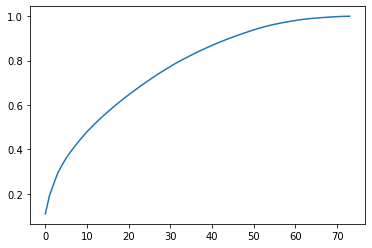

In [59]:
plt.plot(range(0, both_sets.shape[1]), cumsum_pca)
plt.show()

In [60]:
for n_components in range(0,both_sets.shape[1]):
    print("Variance % with", n_components+1, "components: ", round(cumsum_pca[n_components]*100,2), "%")

Variance % with 1 components:  10.87 %
Variance % with 2 components:  19.09 %
Variance % with 3 components:  24.36 %
Variance % with 4 components:  29.32 %
Variance % with 5 components:  32.87 %
Variance % with 6 components:  36.03 %
Variance % with 7 components:  38.71 %
Variance % with 8 components:  41.19 %
Variance % with 9 components:  43.52 %
Variance % with 10 components:  45.78 %
Variance % with 11 components:  47.93 %
Variance % with 12 components:  49.84 %
Variance % with 13 components:  51.71 %
Variance % with 14 components:  53.55 %
Variance % with 15 components:  55.24 %
Variance % with 16 components:  56.91 %
Variance % with 17 components:  58.53 %
Variance % with 18 components:  60.13 %
Variance % with 19 components:  61.66 %
Variance % with 20 components:  63.14 %
Variance % with 21 components:  64.58 %
Variance % with 22 components:  65.99 %
Variance % with 23 components:  67.37 %
Variance % with 24 components:  68.74 %
Variance % with 25 components:  70.06 %
Variance 

About 95% of all the variance lies in the first 54 components. This is a reduction of 20 features compared to the other sets

### Improved PCA

In [61]:
pca = PCA(n_components = 54, random_state = 666)
pca_data = pca.fit_transform(scaled_both_sets)

### Analize the correlation between the original features and the components

In [62]:
column_names = train_set.columns.tolist()

In [63]:
pca_components = pd.DataFrame(pca.components_, columns = column_names)

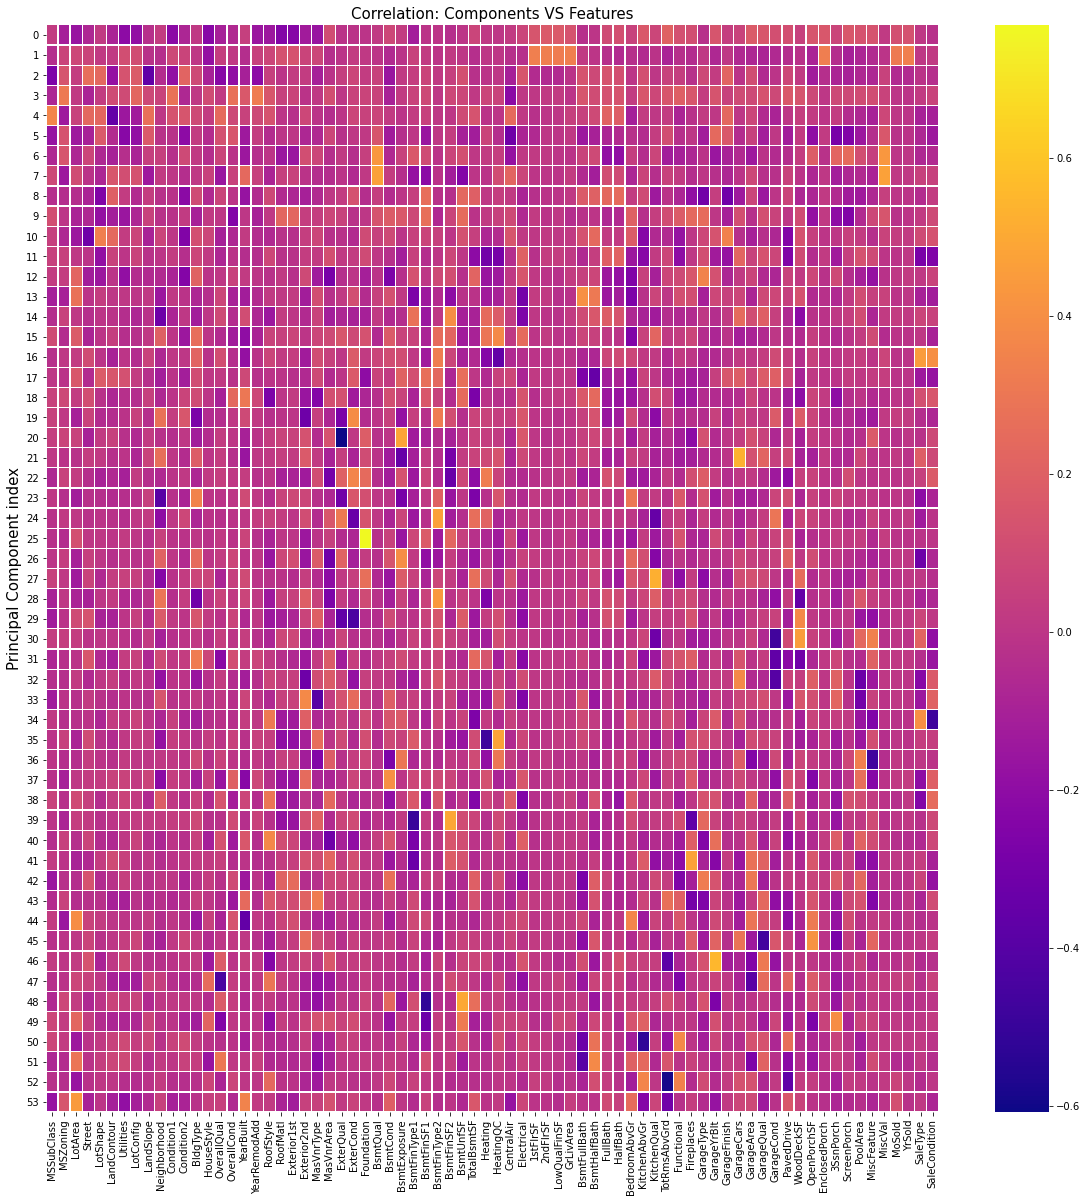

In [64]:
plt.figure(figsize=(20, 20))
sns.heatmap(pca_components,cmap = 'plasma', linewidths = 0.2, linecolor = 'w')
plt.title(label = "Correlation: Components VS Features", loc = "center", fontsize = 15)
plt.ylabel('Principal Component index', fontsize = 15)
plt.yticks(rotation=0)
plt.show()

#### Split the data into train and test set

In [65]:
pca_both_sets = pd.DataFrame(pca_data)

#Number of rows in the train set. This value will be used to split the combined dataset
n_samples_train =  train_set.shape[0]

#Get the encoded train data
pca_train_set = pca_both_sets.iloc[:n_samples_train].copy()
pca_train_set.reset_index(inplace = True)
#Get rid of the extra column added after resetting the indexed
pca_train_set = pca_train_set.drop('index', axis = 1) 

#Get the encoded test data
pca_test_set = pca_both_sets.iloc[n_samples_train:].copy()
pca_test_set.reset_index(inplace = True)
#Get rid of the extra column added after resetting the indexed
pca_test_set = pca_test_set.drop('index', axis = 1) 

#### Make sure all sets have the same shape

In [66]:
print("PCA train set shape:", pca_train_set.shape)
print("PCA test set shape:", pca_test_set.shape)

print("\nRegular train set shape:", encoded_train_set.shape)
print("Regular test set shape:", encoded_test_set.shape)

PCA train set shape: (1453, 54)
PCA test set shape: (1459, 54)

Regular train set shape: (1453, 74)
Regular test set shape: (1459, 74)


# Models

In [67]:
#Regression models for the regular set

gbr = GradientBoostingRegressor(random_state = 37)

randomForest = RandomForestRegressor(random_state = 69)

KNeighbors = KNeighborsRegressor()

lasso = Lasso(random_state = 44)

#Regression models for the PCA set

pca_gbr = GradientBoostingRegressor(random_state = 38)

pca_randomForest = RandomForestRegressor(random_state = 70)

pca_KNeighbors = KNeighborsRegressor()

pca_lasso = Lasso(random_state = 45)

# Find promising parameters

### Grid Search - GradientBoostingRegressor

In [68]:
#Parameter dictionary for the GridsearchCV
gbr_grid_parameters = {"n_estimators": [100, 500, 700], 
                  "learning_rate": [0.001, 0.05],
                  "subsample" : [0.5, 0.75],
                  "max_depth" : [2, 3]}

In [69]:
#K folds 
k_folds = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 55)

#Applying the grid search
gbr_grid_search = GridSearchCV(estimator = gbr, param_grid = gbr_grid_parameters,
                           cv = k_folds, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [70]:
#Fit the train set in the grid search
gbr_grid_result = gbr_grid_search.fit(encoded_train_set, salePrice_train)

In [71]:
#Print results
print("RMSE: ", -gbr_grid_result.best_score_, "\nBest parameters:\n", gbr_grid_result.best_params_)

RMSE:  0.12190643653204364 
Best parameters:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.75}


##### Apply the best parameters to the estimator

In [72]:
best_gbr = GradientBoostingRegressor(max_depth=gbr_grid_result.best_params_['max_depth'],
                                        n_estimators =gbr_grid_result.best_params_['n_estimators'],
                                        learning_rate=gbr_grid_result.best_params_['learning_rate'],
                                        subsample = gbr_grid_result.best_params_['subsample'],
                                        random_state=7)


### Grid Search - PCA GradientBoostingRegressor

In [73]:
#Parameter dictionary for the GridsearchCV
gbr_grid_parameters = {"n_estimators": [100, 500, 700], 
                  "learning_rate": [0.001, 0.05],
                  "subsample" : [0.5, 0.75],
                  "max_depth" : [2, 3]}

In [74]:
#K folds 
k_folds = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 55)

#Applying the grid search
gbr_grid_search = GridSearchCV(estimator = pca_gbr, param_grid = gbr_grid_parameters,
                           cv = k_folds, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [75]:
#Fit the train set in the grid search
gbr_grid_result = gbr_grid_search.fit(pca_train_set, salePrice_train)

In [76]:
#Print results
print("RMSE: ", -gbr_grid_result.best_score_, "\nBest parameters:\n", gbr_grid_result.best_params_)

RMSE:  0.1492742870265103 
Best parameters:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


##### Apply the best parameters to the estimator

In [77]:
best_pca_gbr = GradientBoostingRegressor(max_depth=gbr_grid_result.best_params_['max_depth'],
                                        n_estimators =gbr_grid_result.best_params_['n_estimators'],
                                        learning_rate=gbr_grid_result.best_params_['learning_rate'],
                                        subsample = gbr_grid_result.best_params_['subsample'],
                                        random_state=7)


### RandomizedSearchCV - Random Forest

In [78]:
#Parameter dictionary for the Randomized search
rf_parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 50],
 'max_features': ['sqrt', 'log2', 'auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 500],
 'n_jobs' : [-1]}

In [79]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 83)

#Apply the Randomized search
rf_search = RandomizedSearchCV(estimator = randomForest, param_distributions = rf_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=86, n_jobs = -1)

In [80]:
#Fit the train set in the randomized search
rf_search_result = rf_search.fit(encoded_train_set, salePrice_train)

In [81]:
#Print results
print("RMSE: ", -rf_search_result.best_score_, "\nBest parameters:\n", rf_search_result.best_params_)

RMSE:  0.1369516661904002 
Best parameters:
 {'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


##### Apply the best parameters to the estimator

In [82]:
best_RandomForest = RandomForestRegressor(
                                        n_estimators = rf_search_result.best_params_['n_estimators'],
                                        min_samples_split = rf_search_result.best_params_['min_samples_split'],
                                        min_samples_leaf = rf_search_result.best_params_['min_samples_leaf'],
                                        max_features = rf_search_result.best_params_['max_features'],
                                        max_depth=rf_search_result.best_params_['max_depth'],
                                        bootstrap = rf_search_result.best_params_['bootstrap'],
                                                                    random_state=42)

### RandomizedSearchCV - PCA Random Forest

In [83]:
#Parameter dictionary for the Randomized search
rf_parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 50],
 'max_features': ['sqrt', 'log2', 'auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 500],
 'n_jobs' : [-1]}

In [84]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 83)

#Apply the Randomized search
rf_search = RandomizedSearchCV(estimator = pca_randomForest, param_distributions = rf_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=86, n_jobs = -1)

In [85]:
#Fit the train set in the randomized search
rf_search_result = rf_search.fit(pca_train_set, salePrice_train)

In [86]:
#Print results
print("RMSE: ", -rf_search_result.best_score_, "\nBest parameters:\n", rf_search_result.best_params_)

RMSE:  0.1611077126758906 
Best parameters:
 {'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


##### Apply the best parameters to the estimator

In [87]:
best_pca_RandomForest = RandomForestRegressor(
                                        n_estimators = rf_search_result.best_params_['n_estimators'],
                                        min_samples_split = rf_search_result.best_params_['min_samples_split'],
                                        min_samples_leaf = rf_search_result.best_params_['min_samples_leaf'],
                                        max_features = rf_search_result.best_params_['max_features'],
                                        max_depth=rf_search_result.best_params_['max_depth'],
                                        bootstrap = rf_search_result.best_params_['bootstrap'],
                                                                    random_state=42)

### RandomizedSearchCV - KNeighborsRegressor

In [88]:
#Parameter dictionary for the Randomized search
KNeighbors_parameters = {"n_neighbors" : [3, 5, 10],
                        "weights" : ['uniform', 'distance'],
                        "algorithm" : ['ball_tree', 'kd_tree', 'brute', 'auto'],
                        "leaf_size" : [10, 30, 50],
                        "p" : [1, 2],
                        "n_jobs" : [-1]}

In [89]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 77)

#Apply the Randomized search
KNeighbors_search = RandomizedSearchCV(estimator = KNeighbors, param_distributions = KNeighbors_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=11, n_jobs = -1)

In [90]:
#Fit the train set in the randomized search
KNeighbors_search_result = KNeighbors_search.fit(encoded_train_set, salePrice_train)

In [91]:
print("RMSE: ",-KNeighbors_search_result.best_score_, "\nBest parameters:\n", KNeighbors_search_result.best_params_)

RMSE:  0.16565593231468548 
Best parameters:
 {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'n_jobs': -1, 'leaf_size': 50, 'algorithm': 'ball_tree'}


##### Apply the best parameters to the estimator

In [92]:
best_KNeighbors = KNeighborsRegressor(weights = KNeighbors_search_result.best_params_['weights'],
                                        p = KNeighbors_search_result.best_params_['p'],
                                        n_neighbors = KNeighbors_search_result.best_params_['n_neighbors'],
                                        leaf_size = KNeighbors_search_result.best_params_['leaf_size'],
                                        algorithm = KNeighbors_search_result.best_params_['algorithm'],
                                          n_jobs = -1)

### RandomizedSearchCV - PCA KNeighborsRegressor

In [93]:
#Parameter dictionary for the Randomized search
KNeighbors_parameters = {"n_neighbors" : [3, 5, 10],
                        "weights" : ['uniform', 'distance'],
                        "algorithm" : ['ball_tree', 'kd_tree', 'brute', 'auto'],
                        "leaf_size" : [10, 30, 50],
                        "p" : [1, 2],
                        "n_jobs" : [-1]}

In [94]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 77)

#Apply the Randomized search
KNeighbors_search = RandomizedSearchCV(estimator = pca_KNeighbors, param_distributions = KNeighbors_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=11, n_jobs = -1)

In [95]:
#Fit the train set in the randomized search
KNeighbors_search_result = KNeighbors_search.fit(pca_train_set, salePrice_train)

In [96]:
print("RMSE: ",-KNeighbors_search_result.best_score_, "\nBest parameters:\n", KNeighbors_search_result.best_params_)

RMSE:  0.18538653546594153 
Best parameters:
 {'weights': 'distance', 'p': 2, 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 50, 'algorithm': 'auto'}


##### Apply the best parameters to the estimator

In [97]:
best_pca_KNeighbors = KNeighborsRegressor(weights = KNeighbors_search_result.best_params_['weights'],
                                        p = KNeighbors_search_result.best_params_['p'],
                                        n_neighbors = KNeighbors_search_result.best_params_['n_neighbors'],
                                        leaf_size = KNeighbors_search_result.best_params_['leaf_size'],
                                        algorithm = KNeighbors_search_result.best_params_['algorithm'],
                                          n_jobs = -1)

### RandomizedSearchCV - Lasso

In [98]:
#Parameter dictionary for the Randomized search
lasso_parameters = {"alpha" : [0.0001, 0.0005, 0.001],
                   "fit_intercept" : [True, False],
                   "normalize" : [True, False],
                   "precompute" : [True, False],
                   "warm_start" : [True, False],
                   "selection" : ['cyclic', 'random']}

In [99]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 21)

#Apply the Randomized search
lasso_search = RandomizedSearchCV(estimator = lasso, param_distributions = lasso_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=42, n_jobs = -1)

In [100]:
#Fit the train set in the randomized search
lasso_search_result = lasso_search.fit(encoded_train_set, salePrice_train)

In [101]:
#Print results
print("RMSE: ",-lasso_search_result.best_score_, "\nBest parameters:\n", lasso_search_result.best_params_)

RMSE:  0.14360865248849558 
Best parameters:
 {'warm_start': True, 'selection': 'random', 'precompute': True, 'normalize': False, 'fit_intercept': True, 'alpha': 0.0005}


##### Apply the best parameters to the estimator

In [102]:
best_lasso = Lasso(warm_start = lasso_search_result.best_params_['warm_start'],
                    selection = lasso_search_result.best_params_['selection'],
                    precompute = lasso_search_result.best_params_['precompute'],
                    normalize = lasso_search_result.best_params_['normalize'],
                    fit_intercept = lasso_search_result.best_params_['fit_intercept'],
                    alpha = lasso_search_result.best_params_['alpha'])

### RandomizedSearchCV - PCA Lasso

In [103]:
#Parameter dictionary for the Randomized search
lasso_parameters = {"alpha" : [0.0001, 0.0005, 0.001],
                   "fit_intercept" : [True, False],
                   "normalize" : [True, False],
                   "precompute" : [True, False],
                   "warm_start" : [True, False],
                   "selection" : ['cyclic', 'random']}

In [104]:
#K folds
k_folds = RepeatedKFold(n_splits = 8, n_repeats = 3, random_state = 21)

#Apply the Randomized search
lasso_search = RandomizedSearchCV(estimator = pca_lasso, param_distributions = lasso_parameters, 
                                    n_iter = 20, cv = k_folds, scoring = 'neg_root_mean_squared_error', 
                                    random_state=42, n_jobs = -1)

In [105]:
#Fit the train set in the randomized search
lasso_search_result = lasso_search.fit(pca_train_set, salePrice_train)

In [106]:
#Print results
print("RMSE: ",-lasso_search_result.best_score_, "\nBest parameters:\n", lasso_search_result.best_params_)

RMSE:  0.15239522903605937 
Best parameters:
 {'warm_start': False, 'selection': 'random', 'precompute': False, 'normalize': False, 'fit_intercept': True, 'alpha': 0.001}


##### Apply the best parameters to the estimator

In [107]:
best_pca_lasso = Lasso(warm_start = lasso_search_result.best_params_['warm_start'],
                    selection = lasso_search_result.best_params_['selection'],
                    precompute = lasso_search_result.best_params_['precompute'],
                    normalize = lasso_search_result.best_params_['normalize'],
                    fit_intercept = lasso_search_result.best_params_['fit_intercept'],
                    alpha = lasso_search_result.best_params_['alpha'])

# Check performance of models with Cross Validation

In [108]:
#Cross validation score with K folds. Returns RMSE of the estimator

def crossValScore_KFolds(estimator, X_train, y_train):
    #K folds
    k_folds = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 55)
    
    #Array of cross validation RMSE scores
    rmse_array = -(cross_val_score(estimator, X_train.values, y_train, 
                                   scoring="neg_root_mean_squared_error", cv = k_folds, n_jobs = -1))
    
    #return mean of the scores for this estimator
    return rmse_array.mean() 

In [109]:
#Cross Validation RMSE for GradientBoostingRegressor
rmse_gbr = crossValScore_KFolds(best_gbr, encoded_train_set, salePrice_train)
print("Cross Validation RMSE for GradientBoostinRegressor: ", rmse_gbr)

Cross Validation RMSE for GradientBoostinRegressor:  0.1218152371427515


In [110]:
#Cross Validation RMSE for PCA GradientBoostingRegressor
rmse_gbr = crossValScore_KFolds(best_pca_gbr, pca_train_set, salePrice_train)
print("Cross Validation RMSE for PCA GradientBoostinRegressor: ", rmse_gbr)

Cross Validation RMSE for PCA GradientBoostinRegressor:  0.14965734045191958


In [111]:
#Cross Validation RMSE for RandomForestRegressor
rmse_randomForest = crossValScore_KFolds(best_RandomForest, encoded_train_set, salePrice_train)
print("Cross Validation RMSE for RandomForestRegressor: ", rmse_randomForest)

Cross Validation RMSE for RandomForestRegressor:  0.13590556369094758


In [112]:
#Cross Validation RMSE for PCA RandomForestRegressor
rmse_randomForest = crossValScore_KFolds(best_pca_RandomForest, pca_train_set, salePrice_train)
print("Cross Validation RMSE for PCA RandomForestRegressor: ", rmse_randomForest)

Cross Validation RMSE for PCA RandomForestRegressor:  0.16123447075857752


In [113]:
#Cross Validation RMSE KNeighborsRegressor
rmse_KNeighbors = crossValScore_KFolds(best_KNeighbors, encoded_train_set, salePrice_train)
print("Cross Validation RMSE KNeighborsRegressor: ", rmse_KNeighbors)

Cross Validation RMSE KNeighborsRegressor:  0.1654404229826927


In [114]:
#Cross Validation RMSE PCA KNeighborsRegressor
rmse_KNeighbors = crossValScore_KFolds(best_pca_KNeighbors, pca_train_set, salePrice_train)
print("Cross Validation RMSE KNeighborsRegressor: ", rmse_KNeighbors)

Cross Validation RMSE KNeighborsRegressor:  0.18415959609158206


In [115]:
#Cross Validation RMSE for Lasso
rmse_lasso = crossValScore_KFolds(best_lasso, encoded_train_set, salePrice_train)
print("Cross Validation RMSE for Lasso: ", rmse_lasso)

Cross Validation RMSE for Lasso:  0.14275801517700662


In [116]:
#Cross Validation RMSE for PCA Lasso
rmse_lasso = crossValScore_KFolds(best_pca_lasso, pca_train_set, salePrice_train)
print("Cross Validation RMSE for Lasso: ", rmse_lasso)

Cross Validation RMSE for Lasso:  0.15161681875381758


# Make predictions

In [141]:
#GradientBoostingRegressor
best_gbr.fit(encoded_train_set, salePrice_train)
predictions_GBR = best_gbr.predict(encoded_test_set)

In [142]:
#PCA GradientBoostingRegressor
best_pca_gbr.fit(pca_train_set, salePrice_train)
predictions_pca_GBR = best_pca_gbr.predict(pca_test_set)

In [143]:
#RandomForestRegressor
best_RandomForest.fit(encoded_train_set, salePrice_train)
predictions_RandomForest = best_RandomForest.predict(encoded_test_set)

In [144]:
#PCA RandomForestRegressor
best_pca_RandomForest.fit(pca_train_set, salePrice_train)
predictions_pca_RandomForest = best_pca_RandomForest.predict(pca_test_set)

In [145]:
#KNeighborsRegressor
best_KNeighbors.fit(encoded_train_set, salePrice_train)
predictions_KNeighbors = best_KNeighbors.predict(encoded_test_set)

In [146]:
#PCA KNeighborsRegressor
best_pca_KNeighbors.fit(pca_train_set, salePrice_train)
predictions_pca_KNeighbors = best_pca_KNeighbors.predict(pca_test_set)

In [147]:
#Lasso
best_lasso.fit(encoded_train_set, salePrice_train)
predictions_lasso = best_lasso.predict(encoded_test_set)

In [148]:
#PCA Lasso
best_pca_lasso.fit(pca_train_set, salePrice_train)
predictions_pca_lasso = best_pca_lasso.predict(pca_test_set)

##### Convert predictions into a dataframe

In [149]:
#Models using regular sets

df_predictions_GBR = pd.DataFrame(predictions_GBR, columns = ['SalePrice'])

df_predictions_RandomForest = pd.DataFrame(predictions_RandomForest, columns = ['SalePrice'])

df_predictions_KNeighbors = pd.DataFrame(predictions_KNeighbors, columns = ['SalePrice'])

df_predictions_lasso = pd.DataFrame(predictions_lasso, columns = ['SalePrice'])

In [150]:
#Models using PCA

df_predictions_pca_GBR = pd.DataFrame(predictions_pca_GBR, columns = ['SalePrice'])

df_predictions_pca_RandomForest = pd.DataFrame(predictions_pca_RandomForest, columns = ['SalePrice'])

df_predictions_pca_KNeighbors = pd.DataFrame(predictions_pca_KNeighbors, columns = ['SalePrice'])

df_predictions_pca_lasso = pd.DataFrame(predictions_pca_lasso, columns = ['SalePrice'])

As we applied np.log1p transformation to the target variable. I will apply np.expm1 to the results to transform the prediction values back to its original format in dollars

In [151]:
#Convert predictions back to the normal range by reversing the log1p transformation
#Models using regular sets


predictions_expm1_gbr = np.expm1(df_predictions_GBR['SalePrice'])

predictions_expm1_RandomForest = np.expm1(df_predictions_RandomForest['SalePrice'])

predictions_expm1_KNeighbors = np.expm1(df_predictions_KNeighbors['SalePrice'])

predictions_expm1_lasso = np.expm1(df_predictions_lasso['SalePrice'])

In [152]:
#Convert predictions back to the normal range by reversing the log1p transformation
#Models using PCA

predictions_expm1_pca_gbr = np.expm1(df_predictions_pca_GBR['SalePrice'])

predictions_expm1_pca_RandomForest = np.expm1(df_predictions_pca_RandomForest['SalePrice'])

predictions_expm1_pca_KNeighbors = np.expm1(df_predictions_pca_KNeighbors['SalePrice'])

predictions_expm1_pca_lasso = np.expm1(df_predictions_pca_lasso['SalePrice'])

In [153]:
#Change them back into a data frame
#Models using regular sets

df_predictions_GBR = pd.DataFrame(predictions_expm1_gbr, columns = ['SalePrice'])


df_predictions_RandomForest = pd.DataFrame(predictions_expm1_RandomForest, columns = ['SalePrice'])

df_predictions_KNeighbors = pd.DataFrame(predictions_expm1_KNeighbors, columns = ['SalePrice'])

df_predictions_lasso = pd.DataFrame(predictions_expm1_lasso, columns = ['SalePrice'])

In [154]:
#Change them back into a data frame
#Models using PCA

df_predictions_pca_GBR = pd.DataFrame(predictions_expm1_pca_gbr, columns = ['SalePrice'])


df_predictions_pca_RandomForest = pd.DataFrame(predictions_expm1_pca_RandomForest, columns = ['SalePrice'])

df_predictions_pca_KNeighbors = pd.DataFrame(predictions_expm1_pca_KNeighbors, columns = ['SalePrice'])

df_predictions_pca_lasso = pd.DataFrame(predictions_expm1_pca_lasso, columns = ['SalePrice'])

In [155]:
#Dataframe to hold all the results

predictions = pd.DataFrame(test_id, columns = ['Id'])

In [156]:
#Copy results
#Models using regular sets

predictions['SalePrice_GBR'] = df_predictions_GBR.copy()

predictions['SalePrice_RandomForest'] = df_predictions_RandomForest.copy()

predictions['SalePrice_KNeighbors'] = df_predictions_KNeighbors.copy()

predictions['SalePrice_lasso'] = df_predictions_lasso.copy()

In [157]:
#Copy results
#Models using PCA

predictions['SalePrice_PCA_GBR'] = df_predictions_pca_GBR.copy()

predictions['SalePrice_PCA_RandomForest'] = df_predictions_pca_RandomForest.copy()

predictions['SalePrice_PCA_KNeighbors'] = df_predictions_pca_KNeighbors.copy()

predictions['SalePrice_PCA_lasso'] = df_predictions_pca_lasso.copy()

In [158]:
#Combined predictions of all sets. This combination gave the best score in the competition
#Models using regular sets

predictions['SalePrice_CombinedModels'] = ((predictions['SalePrice_GBR'] * 0.5) 
                                           + (predictions['SalePrice_RandomForest'] * 0.2)
                                           + (predictions['SalePrice_KNeighbors'] * 0.15)
                                           + (predictions['SalePrice_lasso'] * 0.15))

In [159]:
#Combined predictions of all sets. This combination gave the best score in the competition
#Models using PCA

predictions['SalePrice_PCA_CombinedModels'] = ((predictions['SalePrice_PCA_GBR'] * 0.5) 
                                           + (predictions['SalePrice_PCA_RandomForest'] * 0.2)
                                           + (predictions['SalePrice_PCA_KNeighbors'] * 0.15)
                                           + (predictions['SalePrice_PCA_lasso'] * 0.15))

# Results 

In [160]:
predictions.head(10)

,Id,SalePrice_GBR,SalePrice_RandomForest,SalePrice_KNeighbors,SalePrice_lasso,SalePrice_PCA_GBR,SalePrice_PCA_RandomForest,SalePrice_PCA_KNeighbors,SalePrice_PCA_lasso,SalePrice_CombinedModels,SalePrice_PCA_CombinedModels
0,1461,122049.135799,128812.218778,130087.874614,129558.107052,106292.271275,105300.955607,122760.387666,108393.106200,125733.908905,108879.350839
1,1462,158254.919452,156380.829498,149730.687482,168888.766190,146797.627303,148953.505228,152093.477990,141788.083424,158196.543676,147271.748909
2,1463,204547.127994,186385.633145,186068.168030,210941.075609,157665.026303,155859.731832,188880.915295,180870.491585,199102.077172,165467.170550
3,1464,192622.616471,187501.998653,191996.874993,209722.112981,171516.102119,161923.752664,194594.490014,190244.989239,194069.556162,175868.723480
4,1465,197255.574843,182582.430844,170962.072403,187210.981642,147086.099963,143849.821374,175375.316078,163520.200634,188870.231697,153147.341763
5,1466,184064.240768,183879.061891,179881.758175,186613.357295,146782.593594,142661.325400,179730.033271,167341.143766,183782.200083,153984.238433
6,1467,181391.986929,170643.108725,158966.622281,172677.662282,138178.904213,134988.766894,149899.750260,156961.194721,174571.257894,142116.347232
7,1468,174511.209878,175937.974878,176758.925035,170039.149795,141700.178594,135193.170189,176399.356781,156807.389879,174462.911139,147869.735334
8,1469,178872.189669,170974.729800,162443.906085,190202.032234,141704.437768,137415.596655,156823.350349,163093.190037,176527.931542,146322.819273
9,1470,130055.045586,131256.284301,127371.676666,129408.327687,108125.208234,104483.275195,127015.418267,114377.819540,129795.780306,111168.244827


# Submission

In [161]:
#After individally submitting each model's prediction to the competition, the best score was given to the PCA_KNeighbors model
submission = predictions[['Id', 'SalePrice_PCA_KNeighbors']].copy()
submission.columns = ['Id', 'SalePrice']

In [162]:
print(submission)

        Id      SalePrice
0     1461  122760.387666
1     1462  152093.477990
2     1463  188880.915295
3     1464  194594.490014
4     1465  175375.316078
...    ...            ...
1454  2915   95444.546254
1455  2916  105924.573406
1456  2917  141138.406575
1457  2918  123505.658442
1458  2919  202039.940194

[1459 rows x 2 columns]


In [163]:
#submission.to_csv('submission_PCA_housingPrices.csv',index=False)